In [1]:
import pandas as pd
import numpy as np
import re
import gensim
from gensim import corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim.summarization.summarizer import summarize
from gensim.summarization import keywords
import spacy
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from nltk import FreqDist
from gensim.models.phrases import Phrases, Phraser
from nltk import sent_tokenize, word_tokenize
from string import punctuation
import os
import codecs
from sklearn import feature_extraction
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import pairwise_distances_argmin_min
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import model_selection, naive_bayes, svm
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix

pd.set_option("display.max_colwidth", 10000)

%matplotlib inline

In [2]:
df = pd.read_csv('C:/Users/wongzn/Desktop/Transfer/df.csv')
LDA_topics = pd.read_csv('C:/Users/wongzn/Desktop/LDA_topics.csv')
df_sup = pd.read_csv('C:/Users/wongzn/Desktop/topics.csv')

# Summarising Using GENSIM

In [3]:
df = pd.concat([df,LDA_topics['Dominant_Topic']],axis=1)

In [4]:
df = df[df['Topics'] != 'LIVE BLOG']
df = df[~df['Article Content'].str.contains("ST Now")]

### Preprocessing For Keywords Extraction and Article Summarisation

In [5]:
def preprocess_content(column):
    column = column.apply(lambda x: re.sub(r'\([^)]*\)', '',x)) #remove (anything in brackets)
    column = column.apply(lambda x: re.sub(r'\d{2}[/-]\w{4}[/-]\w{3,4}', '',x)) #remove(xx-year-old)
    column = column.apply(lambda x: re.sub(r'straits times','',x, flags=re.IGNORECASE))
    column = column.apply(lambda x: re.sub(r'per cent','',x, flags=re.IGNORECASE))
    #column = column.apply(lambda x: re.sub('.\d+.', ' ', x)) #removing digits 
    column = column.apply(lambda x: re.sub(r'cpl kok yuen chin','',x, flags=re.IGNORECASE))
    column = column.apply(lambda x: re.sub(r'corporal kok yuen chin','',x, flags=re.IGNORECASE))
    column = column.apply(lambda x: re.sub(r'cpl kok','',x, flags=re.IGNORECASE))
    column = column.apply(lambda x: re.sub(r'singapore - ','',x, flags=re.IGNORECASE))
    column = column.apply(lambda x: re.sub(r'SINGAPORE –','',x, flags=re.IGNORECASE))
    #column = column.apply(lambda x: x.lower()) #convert to lowercase
    column = column.apply(lambda x: re.sub('\n','',x))
    return column

df['Article Content'] = preprocess_content(df['Article Content'])

In [6]:
nlp = spacy.load('en_core_web_sm')
stop_words = spacy.lang.en.stop_words.STOP_WORDS
add_words = ["singapore","said","also","year","month", "time", "last", "years"]
stop_words.update(add_words)

In [7]:
def remove_stopwords(content):
    content_new = ' '.join([i for i in content if i not in stop_words])
    return content_new

df['Article Content'] = df['Article Content'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>1]))

#Stop here for data for summarisation

In [8]:
Article_content = [remove_stopwords(r.split()) for r in df['Article Content']]

In [9]:
def lemmatization(texts, tags=['NOUN','ADJ','ADV','VERB']):
    output=[]
    for sent in texts:
        doc = nlp(" ".join(sent))
        output.append([token.lemma_ for token in doc if token.pos_ in tags])
    return output

In [10]:
tokenized_contents = pd.Series(Article_content).apply(lambda x: x.split())
#print(tokenized_contents[0])

In [11]:
lemmatized_contents = lemmatization(tokenized_contents,tags=['NOUN','ADJ','VERB','ADV']) 
#print(lemmatized_contents[0])

In [12]:
def remove_stopwords(texts):
    return [[word for word in doc if word.lower() not in stop_words] for doc in texts]

In [13]:
no_stops = remove_stopwords(lemmatized_contents)

In [14]:
Article_content_clean = []
for i in range(len(no_stops)):
    Article_content_clean.append(' '.join(no_stops[i]))
df['Keywords Content'] = Article_content_clean

#Stop here for data for keywords extraction

In [15]:
df.reset_index(inplace=True)
df.rename(columns={'Dominant_Topic': 'Dominant Topic'},inplace=True)

In [16]:
summarize(df['Article Content'][0],ratio=0.2,word_count=80)

'Malaysian suspect was arrested at the junction of Shenton Way and Maxwell Road last Thursday after he allegedly disposed of plastic bag containing 336g of Ice at carpark in the vicinity of Orchard Towers.\nThey also recovered the plastic bag which contained 336g of Ice, valued at $33,000.\nThree other suspected drug offenders, including Singaporean man, were arrested at Orchard Towers and the International Building last Thursday.'

# Code For Keywords Extraction Using Gensim

In [17]:
df['Article Content Keywords'] = df['Keywords Content'].apply(lambda x: keywords(x, words=10,lemmatize=True,split=True,deacc=True))

## Constructing Wordcloud For Each Topic Based On Keywords Extracted

In [18]:
from PIL import Image
import random
from wordcloud import WordCloud

cloud_mask = np.array(Image.open("C:/Users/wongzn/Desktop/Cloud.jpg"))

def grey_color_func(word, font_size, position, orientation, random_state=None,**kwargs):
    return "hsl(0, 0%%, %d%%)" % random.randint(10, 40)

In [19]:
def find_topic_keywords(topic='Unknown', num_keywords=10):
    kw = []
    kw_new = []
    for i in range(len(df)):
        if df['Dominant Topic'][i] == topic:
            kw.append(' '.join(df['Article Content Keywords'][i]))
    
    for j in range(len(kw)):
        kw_new.append(kw[j].split())
    
    flat_list = [item for sublist in kw_new for item in sublist]
    flat_list = pd.DataFrame(flat_list)
    flat_list.rename(columns={0:'Keywords'}, inplace=True)
    flat_list = pd.DataFrame({'Frequency':flat_list.Keywords.value_counts()[:num_keywords]})
    flat_list = flat_list.rename_axis('Keywords').reset_index()
    d={}
    plt.figure(figsize=(20,8))
    for a in range(len(flat_list)):
        d[flat_list['Keywords'][a]]= flat_list['Frequency'][a]
    wordcloud=WordCloud(background_color="white", max_font_size=200, min_font_size=10,mask=cloud_mask,color_func = grey_color_func)
    wordcloud.generate_from_frequencies(frequencies=d)
    
    plt.imshow(wordcloud)
    plt.axis("off")
    return(flat_list[:10])

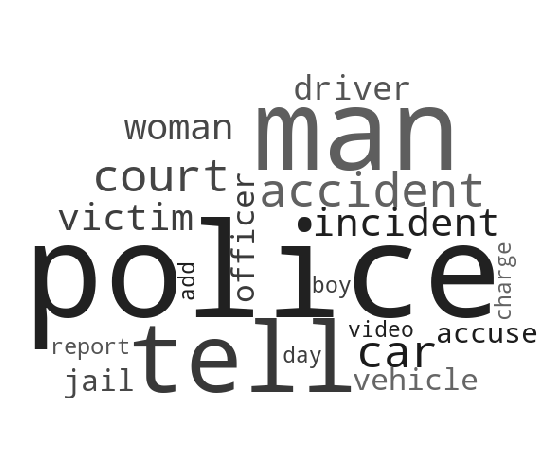

In [20]:
#WordCloud

topics = ['Accidents', 'Air and Road Transport','Crime','Crime (Cheat and Scams)', 'Diseases and Healthcare','Education and Community (Care and Support)','Employment and Technological Improvement','Food, Water, Waste', 'Housing and Living','Issues in Society','National Security and Global Issues',
'Road Safety and PMD (Related News|Accidents)','Unknown','Weather']
for i in topics:
    find_topic_keywords(i,20)

# Code For Article Summarisation Using Gensim (TextRank)

In [21]:
df['Article Content Summary TextRank'] = df['Article Content'].apply(lambda x: summarize(x, ratio=0.1,word_count=50))

# Output Of Keywords Extraction and Summarisation Using Gensim

In [22]:
kw_col = []
for doc in range(len(df['Article Content Keywords'])):
    kw=[]
    for word in range(len(df['Article Content Keywords'][doc])):
        kw.append(df['Article Content Keywords'][doc][word].split())
        flat_list = [item for sublist in kw for item in sublist]
    kw_col.append(flat_list)
    
KW = []
for i in range(len(kw_col)):
    KW.append(', '.join(kw_col[i]))
df['Article Keywords'] = KW

In [23]:
df[['Article Title','Article Content Keywords','Article Content Summary TextRank']].head()

,Article Title,Article Content Keywords,Article Content Summary TextRank
0,Malaysian drug suspect arrested at Shenton Way junction after attempting hasty getaway on motorbike,"[suspect arrest, drug, include, carpark, seize, operation, plastic, bottle, psychoactive]","Malaysian suspect was arrested at the junction of Shenton Way and Maxwell Road last Thursday after he allegedly disposed of plastic bag containing 336g of Ice at carpark in the vicinity of Orchard Towers.\nThree other suspected drug offenders, including Singaporean man, were arrested at Orchard Towers and the International Building last Thursday."
1,"SCDF ragging death: Being submerged in dark, confined well could be dangerous even for a swimmer, says expert","[water person, add, entering, officer, possible, drown, head, injury, trial]","Dr Paul, who performed the autopsy on said: ""There is also difference between how one reacts when he is prepared to enter the water or when it is sudden unexpected event."" If it is unexpected, it could also result in startled ""inhalatory response"" that causes the person to breathe in water, he said, adding that it is common misconception that when somebody enters body of water, he or she will float."
2,Use technology to help people with special needs integrate as part of Smart Nation push: President Halimah,"[student society, school, community, visit, need, technology, better, train, vocational]","The Republic should leverage on technology such as virtual simulation systems to better integrate people with special needs, including students, into society, said President Halimah Yacob.\nHe is year one student pursuing an ITE Skills Certificate in Housekeeping Operations ST PHOTO: LIM YAOHUI This is Madam Halimah's fourth visit this year to school that supports students with special needs."
3,Work group's report aims to make medical disciplinary process fairer and faster,"[doctor, complaint, patient, work, group, disciplinary, case, tell, medical, meet]","work group tasked with improving the medical watchdog's disciplinary process is looking at having sitting judge and permanent team of senior retired doctors to judge disciplinary cases, and screener who will ensure the system is not bogged down by frivolous complaints."
4,"$1.25m 4-D win: Wife has equal share in husband's prize money, rules apex court","[win, wife, court, party, contribution, ticket, case, matrimonial, husband, divorce]","""The more important point is the intention with which that ticket was purchased,"" said Judge of Appeal Phang on Thursday on behalf of the court, which included Justices Belinda Ang and Woo Bih Li. The High Court last year had held that the husband who bought the winning $1.25 million Singapore Pools 4-D ticket can treat the sum as his contribution to the purchase of the family home, without the wife having any share in the contribution."


# Article Summarisation With Cosine Similarity

In [24]:
def find_similarities(text):
    sentences = sent_tokenize(text)
    stops = list(set(stopwords.words('english'))) + list(punctuation)
    vectorizer = TfidfVectorizer(stop_words = stops)
    trsfm=vectorizer.fit_transform(sentences)
    
    text_df = pd.DataFrame(trsfm.toarray(),columns=vectorizer.get_feature_names(),index=sentences)
    
    num_sentences = text_df.shape[0]
    num_summary_sentences = int(np.ceil(num_sentences**.5))
        
    similarities = cosine_similarity(trsfm, trsfm)
    avgs = []
    for i in similarities:
        avgs.append(i.mean())
    top_idx = np.argsort(avgs)[-num_summary_sentences:]
    
    return top_idx

In [25]:
def build_summary(text):
    sents_for_sum = find_similarities(text)
    sort = sorted(sents_for_sum)[0:1]
    sent_list = sent_tokenize(text)
    sents = []
    for i in sort:
        sents.append(sent_list[i].replace('\n', ''))
    summary = ' '.join(sents)
    return summary

In [26]:
df['Article Content Summary Cosine Similarity'] = df['Article Content'].apply(lambda x: build_summary(x))

In [27]:
df[['Article Title','Article Content Keywords','Article Content Summary TextRank','Article Content Summary Cosine Similarity']].head()

,Article Title,Article Content Keywords,Article Content Summary TextRank,Article Content Summary Cosine Similarity
0,Malaysian drug suspect arrested at Shenton Way junction after attempting hasty getaway on motorbike,"[suspect arrest, drug, include, carpark, seize, operation, plastic, bottle, psychoactive]","Malaysian suspect was arrested at the junction of Shenton Way and Maxwell Road last Thursday after he allegedly disposed of plastic bag containing 336g of Ice at carpark in the vicinity of Orchard Towers.\nThree other suspected drug offenders, including Singaporean man, were arrested at Orchard Towers and the International Building last Thursday.",Malaysian suspect was arrested at the junction of Shenton Way and Maxwell Road last Thursday after he allegedly disposed of plastic bag containing 336g of Ice at carpark in the vicinity of Orchard Towers.
1,"SCDF ragging death: Being submerged in dark, confined well could be dangerous even for a swimmer, says expert","[water person, add, entering, officer, possible, drown, head, injury, trial]","Dr Paul, who performed the autopsy on said: ""There is also difference between how one reacts when he is prepared to enter the water or when it is sudden unexpected event."" If it is unexpected, it could also result in startled ""inhalatory response"" that causes the person to breathe in water, he said, adding that it is common misconception that when somebody enters body of water, he or she will float.","Dr Paul, who performed the autopsy on said: ""There is also difference between how one reacts when he is prepared to enter the water or when it is sudden unexpected event."""
2,Use technology to help people with special needs integrate as part of Smart Nation push: President Halimah,"[student society, school, community, visit, need, technology, better, train, vocational]","The Republic should leverage on technology such as virtual simulation systems to better integrate people with special needs, including students, into society, said President Halimah Yacob.\nHe is year one student pursuing an ITE Skills Certificate in Housekeeping Operations ST PHOTO: LIM YAOHUI This is Madam Halimah's fourth visit this year to school that supports students with special needs.","The Republic should leverage on technology such as virtual simulation systems to better integrate people with special needs, including students, into society, said President Halimah Yacob."
3,Work group's report aims to make medical disciplinary process fairer and faster,"[doctor, complaint, patient, work, group, disciplinary, case, tell, medical, meet]","work group tasked with improving the medical watchdog's disciplinary process is looking at having sitting judge and permanent team of senior retired doctors to judge disciplinary cases, and screener who will ensure the system is not bogged down by frivolous complaints.","work group tasked with improving the medical watchdog's disciplinary process is looking at having sitting judge and permanent team of senior retired doctors to judge disciplinary cases, and screener who will ensure the system is not bogged down by frivolous complaints."
4,"$1.25m 4-D win: Wife has equal share in husband's prize money, rules apex court","[win, wife, court, party, contribution, ticket, case, matrimonial, husband, divorce]","""The more important point is the intention with which that ticket was purchased,"" said Judge of Appeal Phang on Thursday on behalf of the court, which included Justices Belinda Ang and Woo Bih Li. The High Court last year had held that the husband who bought the winning $1.25 million Singapore Pools 4-D ticket can treat the sum as his contribution to the purchase of the family home, without the wife having any share in the contribution.","Singapore's apex court has ruled that the lottery winnings of spouse are part of couple's matrimonial assets to be shared equally, when the ticket is bought with the intention of benefiting the family instead of the winner alone."


In [28]:
summary_content = df[['Article Title','Article Content Summary Cosine Similarity']].to_csv('C:/Users/wongzn/Desktop/summary_content.csv',index=False)

# Evaluation Metrics for Article Summary

### Looking At Rouge Score Between Golden Summary (Article Title) VS Machine Summary

In [29]:
#Preprocessing of Golden Summary (Article Title)
Article_content_ref = preprocess_content(df['Article Title'])
tokenized_contents_ref = pd.Series(Article_content_ref).apply(lambda x: x.split())
lemmatized_contents_ref = lemmatization(tokenized_contents_ref) 
ref_lemmatized = remove_stopwords(lemmatized_contents_ref)

In [30]:
#Preprocessing of Machine Summary 
Article_content_cosine = preprocess_content(df['Article Content Summary Cosine Similarity'])
tokenized_contents_cosine = pd.Series(Article_content_cosine).apply(lambda x: x.split())
lemmatized_contents_cosine = lemmatization(tokenized_contents_cosine) 
sum_lemmatized_cosine = remove_stopwords(lemmatized_contents_cosine)

In [31]:
recall1 = []
precision1 = []
rouge1 = []

from rouge.rouge import rouge_n_sentence_level

for row in range(len(df['Article Content'])):
    recall, precision, rouge = rouge_n_sentence_level(ref_lemmatized[row], sum_lemmatized_cosine[row], 1)
    recall1.append(recall)
    precision1.append(precision)
    rouge1.append(rouge)

In [32]:
Summary_Evaluation = pd.DataFrame()

Summary_Evaluation['recall'] = recall1
Summary_Evaluation['precision'] = precision1
Summary_Evaluation['rouge'] = rouge1
Summary_Evaluation.describe()

,recall,precision,rouge
count,2598.000000,2598.000000,2598.000000
mean,0.261271,0.468935,0.317348
std,0.202937,0.314040,0.221127
min,0.000000,0.000000,0.000000
25%,0.111111,0.200000,0.142857
50%,0.229021,0.500000,0.307692
75%,0.368421,0.714286,0.465385
max,1.000000,1.000000,1.000000


### Predicting Topic of Machine Summary With LDA Model

In [33]:
from gensim.test.utils import datapath
import gensim

temp_file = datapath("C:/Users/wongzn/Desktop/LDA_model")
lda = gensim.models.ldamodel.LdaModel.load(temp_file)

INFO:gensim.corpora.dictionary:adding document #0 to Dictionary(0 unique tokens: [])
INFO:gensim.corpora.dictionary:built Dictionary(12 unique tokens: ['computer', 'human', 'interface', 'response', 'survey']...) from 9 documents (total 29 corpus positions)
INFO:gensim.utils:loading LdaModel object from C:/Users/wongzn/Desktop/LDA_model
INFO:gensim.utils:loading expElogbeta from C:/Users/wongzn/Desktop/LDA_model.expElogbeta.npy with mmap=None
INFO:gensim.utils:setting ignored attribute dispatcher to None
INFO:gensim.utils:setting ignored attribute state to None
INFO:gensim.utils:setting ignored attribute id2word to None
INFO:gensim.utils:loaded C:/Users/wongzn/Desktop/LDA_model
INFO:gensim.utils:loading LdaState object from C:/Users/wongzn/Desktop/LDA_model.state
INFO:gensim.utils:loaded C:/Users/wongzn/Desktop/LDA_model.state


In [34]:
eval_cos_sum = pd.merge(df_sup[['Article Title','Clean Contents','Dominant Topic']],df[['Article Title','Article Content Summary Cosine Similarity']],how='inner',on='Article Title')
eval_cos_sum = eval_cos_sum[['Article Title','Article Content Summary Cosine Similarity','Dominant Topic']]
eval_cos_sum.head()

,Article Title,Article Content Summary Cosine Similarity,Dominant Topic
0,Malaysian drug suspect arrested at Shenton Way junction after attempting hasty getaway on motorbike,Malaysian suspect was arrested at the junction of Shenton Way and Maxwell Road last Thursday after he allegedly disposed of plastic bag containing 336g of Ice at carpark in the vicinity of Orchard Towers.,Crime
1,"SCDF ragging death: Being submerged in dark, confined well could be dangerous even for a swimmer, says expert","Dr Paul, who performed the autopsy on said: ""There is also difference between how one reacts when he is prepared to enter the water or when it is sudden unexpected event.""",Accidents
2,Use technology to help people with special needs integrate as part of Smart Nation push: President Halimah,"The Republic should leverage on technology such as virtual simulation systems to better integrate people with special needs, including students, into society, said President Halimah Yacob.",Education and Community (Care and Support)
3,Work group's report aims to make medical disciplinary process fairer and faster,"work group tasked with improving the medical watchdog's disciplinary process is looking at having sitting judge and permanent team of senior retired doctors to judge disciplinary cases, and screener who will ensure the system is not bogged down by frivolous complaints.",Crime
4,"$1.25m 4-D win: Wife has equal share in husband's prize money, rules apex court","Singapore's apex court has ruled that the lottery winnings of spouse are part of couple's matrimonial assets to be shared equally, when the ticket is bought with the intention of benefiting the family instead of the winner alone.",Housing and Living


### Preprocessing Article Summary and Article Title for LDA Prediction (Model From Task 1)

In [35]:
def tokenize_words(column):
    for word in column:
        yield(gensim.utils.simple_preprocess(str(word),deacc=True))
   
def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent))
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word.lower() not in stop_words] for doc in texts]

In [36]:
eval_cos_sum['Article Content Summary Cosine Similarity'] = eval_cos_sum['Article Content Summary Cosine Similarity'].astype(str)
eval_cos_sum['Article Content Summary Cosine Similarity'] = preprocess_content(eval_cos_sum['Article Content Summary Cosine Similarity'])

data_words_test = list(tokenize_words(eval_cos_sum['Article Content Summary Cosine Similarity']))
bigram = Phrases(data_words_test,min_count=3, threshold=100)
bigram_mod = Phraser(bigram)
data_words_bigrams_test = make_bigrams(remove_stopwords(data_words_test))

data_lemmatized_test = lemmatization(data_words_bigrams_test, allowed_postags=['NOUN', 'ADJ','VERB'])
data_words_nostops_test = remove_stopwords(data_lemmatized_test)

Article_content_clean = []
for i in range(len(data_words_nostops_test)):
    Article_content_clean.append(' '.join(data_words_nostops_test[i]))
eval_cos_sum['Clean Contents'] = Article_content_clean

INFO:gensim.models.phrases:collecting all words and their counts
INFO:gensim.models.phrases:PROGRESS: at sentence #0, processed 0 words and 0 word types
INFO:gensim.models.phrases:collected 56950 word types from a corpus of 85022 words (unigram + bigrams) and 2598 sentences
INFO:gensim.models.phrases:using 56950 counts as vocab in Phrases<0 vocab, min_count=3, threshold=100, max_vocab_size=40000000>
INFO:gensim.models.phrases:source_vocab length 56950
INFO:gensim.models.phrases:Phraser built with 379 phrasegrams


In [37]:
Train_X = df_sup['Clean Contents']
Test_X = eval_cos_sum['Clean Contents']
Train_Y = df_sup['Dominant Topic']

In [38]:
Tfidf_vect = TfidfVectorizer(lowercase=True, min_df=5,max_df=0.9)
Tfidf_vect.fit(Train_X)

Train_X_Tfidf = Tfidf_vect.transform(Train_X)
Test_X_Tfidf = Tfidf_vect.transform(Test_X)

In [39]:
SVM = svm.SVC(C=1.6, kernel='linear', degree=3, random_state=1)
SVM.fit(Train_X_Tfidf,Train_Y)

# predict the labels on validation dataset
sum_predictions_SVM = SVM.predict(Test_X_Tfidf)

In [40]:
summary_accuracy_LDA_Topic = pd.concat([eval_cos_sum,pd.DataFrame(sum_predictions_SVM)],axis=1)
summary_accuracy_LDA_Topic.rename(columns={0:'Predicted Summary Topics'},inplace=True)
summary_accuracy_LDA_Topic[['Article Title', 'Article Content Summary Cosine Similarity','Dominant Topic','Predicted Summary Topics']].head()

,Article Title,Article Content Summary Cosine Similarity,Dominant Topic,Predicted Summary Topics
0,Malaysian drug suspect arrested at Shenton Way junction after attempting hasty getaway on motorbike,Malaysian suspect was arrested at the junction of Shenton Way and Maxwell Road last Thursday after he allegedly disposed of plastic bag containing 336g of Ice at carpark in the vicinity of Orchard Towers.,Crime,Crime
1,"SCDF ragging death: Being submerged in dark, confined well could be dangerous even for a swimmer, says expert","Dr Paul, who performed the autopsy on said: ""There is also difference between how one reacts when he is prepared to enter the water or when it is sudden unexpected event.""",Accidents,Education and Community (Care and Support)
2,Use technology to help people with special needs integrate as part of Smart Nation push: President Halimah,"The Republic should leverage on technology such as virtual simulation systems to better integrate people with special needs, including students, into society, said President Halimah Yacob.",Education and Community (Care and Support),Education and Community (Care and Support)
3,Work group's report aims to make medical disciplinary process fairer and faster,"work group tasked with improving the medical watchdog's disciplinary process is looking at having sitting judge and permanent team of senior retired doctors to judge disciplinary cases, and screener who will ensure the system is not bogged down by frivolous complaints.",Crime,Crime
4,"$1.25m 4-D win: Wife has equal share in husband's prize money, rules apex court","Singapore's apex court has ruled that the lottery winnings of spouse are part of couple's matrimonial assets to be shared equally, when the ticket is bought with the intention of benefiting the family instead of the winner alone.",Housing and Living,Housing and Living


In [41]:
import sklearn
sklearn.metrics.precision_recall_fscore_support(summary_accuracy_LDA_Topic['Dominant Topic'],summary_accuracy_LDA_Topic['Predicted Summary Topics'],average='weighted')

(0.7620288696134745, 0.7417244033872209, 0.7389012732713472, None)

### Predicting Topic Of A Random Sentence With LDA Model

In [103]:
#Choosing a random sentence

from random import randrange

summary = []
length =[]
for i in range(len(df)):
    a = len(nltk.sent_tokenize(df['Article Content'][i]))
    choose = randrange(0,a)
    #length.append(choose)
    summary.append(nltk.sent_tokenize(df['Article Content'][i])[choose])

In [104]:
df['Random Summary'] = summary 
random_summary_accuracy_LDA_Topic = pd.merge(df_sup[['Article Title','Clean Contents','Dominant Topic']],df[['Article Title','Random Summary']],how='inner',on='Article Title')

In [105]:
random_summary_accuracy_LDA_Topic['Random Summary'] = random_summary_accuracy_LDA_Topic['Random Summary'].astype(str)
random_summary_accuracy_LDA_Topic['Random Summary'] = preprocess_content(random_summary_accuracy_LDA_Topic['Random Summary'])
data_words_test = list(tokenize_words(random_summary_accuracy_LDA_Topic['Random Summary']))
data_words_bigrams_test = make_bigrams(remove_stopwords(data_words_test))
data_lemmatized_test = lemmatization(data_words_bigrams_test, allowed_postags=['NOUN', 'ADJ','VERB'])
data_words_nostops_test = remove_stopwords(data_lemmatized_test)

Article_content_clean = []
for i in range(len(data_words_nostops_test)):
    Article_content_clean.append(' '.join(data_words_nostops_test[i]))
random_summary_accuracy_LDA_Topic['Clean Contents (Random)'] = Article_content_clean

In [106]:
Train_X = df_sup['Clean Contents']
Test_X = random_summary_accuracy_LDA_Topic['Clean Contents (Random)']
Train_Y = df_sup['Dominant Topic']

In [107]:
Tfidf_vect = TfidfVectorizer(lowercase=True, min_df=5,max_df=0.9)
Tfidf_vect.fit(Train_X)

Train_X_Tfidf = Tfidf_vect.transform(Train_X)
Test_X_Tfidf = Tfidf_vect.transform(Test_X)

In [108]:
SVM = svm.SVC(C=1.6, kernel='linear', degree=3, random_state=1)
SVM.fit(Train_X_Tfidf,Train_Y)

# predict the labels on validation dataset
random_sum_predictions_SVM = SVM.predict(Test_X_Tfidf)

In [109]:
import sklearn
sklearn.metrics.precision_recall_fscore_support(random_summary_accuracy_LDA_Topic['Dominant Topic'],random_sum_predictions_SVM,average='weighted')

(0.6281910515973391, 0.5758275596612779, 0.5711125400726709, None)

In [110]:
summary_accuracy_LDA_Topic_final = pd.concat([summary_accuracy_LDA_Topic[['Article Title', 'Article Content Summary Cosine Similarity','Dominant Topic','Predicted Summary Topics']],random_summary_accuracy_LDA_Topic['Random Summary'],pd.DataFrame(random_sum_predictions_SVM)],axis=1)

In [111]:
summary_accuracy_LDA_Topic_final.rename(columns={'Article Content Summary Cosine Similarity':'Actual Summary','Dominant Topic':'Dominant Topic of Article Content','Predicted Summary Topics':'Predicted Summary Topics (Actual)', 'Random Summary':'Random Sentence',0:'Predicted Summary Topics (Random)'},inplace=True)
summary_accuracy_LDA_Topic_final[['Article Title', 'Actual Summary','Random Sentence','Dominant Topic of Article Content','Predicted Summary Topics (Actual)', 'Predicted Summary Topics (Random)']].head()

,Article Title,Actual Summary,Random Sentence,Dominant Topic of Article Content,Predicted Summary Topics (Actual),Predicted Summary Topics (Random)
0,Malaysian drug suspect arrested at Shenton Way junction after attempting hasty getaway on motorbike,Malaysian suspect was arrested at the junction of Shenton Way and Maxwell Road last Thursday after he allegedly disposed of plastic bag containing 336g of Ice at carpark in the vicinity of Orchard Towers.,"Some 192 suspected drug offenders were arrested as part of the operation, which covered areas including Bedok, Bukit Merah, Choa Chu Kang, Hougang, Sembawang, Tampines, Telok Blangah and Yishun.",Crime,Crime,Crime
1,"SCDF ragging death: Being submerged in dark, confined well could be dangerous even for a swimmer, says expert","Dr Paul, who performed the autopsy on said: ""There is also difference between how one reacts when he is prepared to enter the water or when it is sudden unexpected event.""",Forensic pathologist George Paul was pointing this out as he testified on Friday in the ongoing trial of two commanders of the Singapore Civil Defence Force linked with the drowning of full-time national serviceman which happened during ragging incident.,Accidents,Education and Community (Care and Support),Accidents
2,Use technology to help people with special needs integrate as part of Smart Nation push: President Halimah,"The Republic should leverage on technology such as virtual simulation systems to better integrate people with special needs, including students, into society, said President Halimah Yacob.","Her comments follow courtesy call by Prince Daniel, member of Sweden's royal family, on Wednesday.",Education and Community (Care and Support),Education and Community (Care and Support),Crime
3,Work group's report aims to make medical disciplinary process fairer and faster,"work group tasked with improving the medical watchdog's disciplinary process is looking at having sitting judge and permanent team of senior retired doctors to judge disciplinary cases, and screener who will ensure the system is not bogged down by frivolous complaints.","The work group has met more than 1,000 doctors from seven other private hospitals and the three public clusters and plans to talk to others like patient advocacy groups and medical specialist chapters in the Academy of Medicine before drafting their report, due to be out before the end of the year.",Crime,Crime,Education and Community (Care and Support)
4,"$1.25m 4-D win: Wife has equal share in husband's prize money, rules apex court","Singapore's apex court has ruled that the lottery winnings of spouse are part of couple's matrimonial assets to be shared equally, when the ticket is bought with the intention of benefiting the family instead of the winner alone.","After their divorce, the High Court allotted the man 58 of the matrimonial assets worth $9.3 million, and the woman, 42 The wife filed an appeal and her lawyers Linda Ong and Lim Xiao Wei argued that given the ""fortuitous nature"" of lottery win, the contributions towards the purchase of the matrimonial home from the prize money should be apportioned equally between the husband and wife, and not solely to the man.",Housing and Living,Housing and Living,Crime
